In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
%matplotlib inline

# Maze Construction

In [150]:
def open_maze(size):
    return np.ones((size, size))

def circular_maze(size):
    r = size // 2 - 1
    a, b = r, r

    y,x = np.ogrid[-a:size-a, -b:size-b]
    mask = x*x + y*y <= r*r

    maze = np.zeros((size, size))
    maze[mask] = 1
    return maze

def trapezoidal_maze(size, repeats=5):
    tri_idx = np.triu_indices(size)
    base_maze = np.ones((size, size))
    base_maze[tri_idx] = 0
    maze_upper = np.repeat(base_maze, repeats, axis=1)
    maze_lower = np.flip(maze_upper, axis=0)
    maze_mid = np.ones((size, size*repeats))
    maze = np.vstack([maze_upper, maze_mid, maze_lower])
    return maze

def hexagonal_maze(size):
    tri_idx = np.triu_indices(size)
    tri_maze = np.ones((size, size))
    tri_maze[tri_idx] = 0
    
    upper = np.hstack([np.flip(tri_maze, axis=1), np.ones((size, int(size*1.7))), tri_maze])
    upper = np.repeat(upper, 2, axis=0)
    lower = np.flip(upper, axis=0)
    mid = np.ones((size, 3*size))
    return np.vstack([upper, lower])
    
def hairpin_maze():
    return np.array([
        [1,1,1,1,1],
        [1,0,1,0,1],
        [1,0,1,0,1],
        [1,0,1,0,1],
        [1,1,1,1,1]
    ])


def multicomp_maze():
    maze = np.ones((20, 20))
    maze[:, 10] = 0
    maze[13, range(10)] = 0
    maze[7, range(10, 20)] = 0
    maze[10,10] = 1
    maze[13,5] = 1
    maze[7,15] = 1
    return maze


def multicomp_maze_circ():
    maze = np.ones((20, 20))
    maze[:, 10] = 0
    maze[13, range(10)] = 0
    maze[7, range(10, 20)] = 0
    maze[3,10] = 1
    maze[16,10] = 1
    maze[13,5] = 1
    maze[7,15] = 1
    return maze

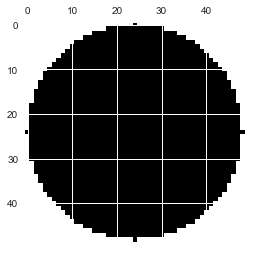

In [87]:
plt.matshow(circular_maze(50))

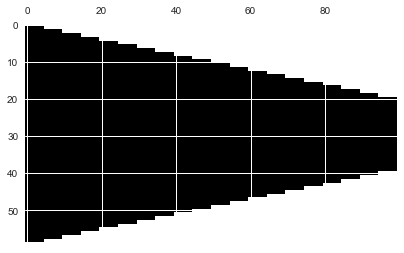

In [88]:
plt.matshow(trapezoidal_maze(20, 5))

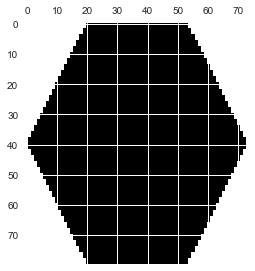

In [65]:
plt.matshow(hexagonal_maze(20))

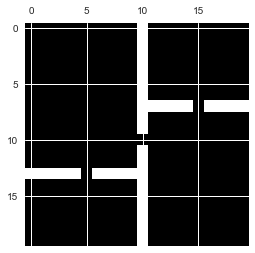

In [151]:
plt.matshow(multicomp_maze())

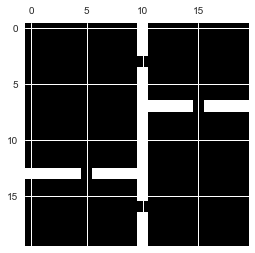

In [152]:
plt.matshow(multicomp_maze_circ())

# TD Learning

In [8]:

r = np.array([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,1,0],
    [0,0,0,-1,0],
    [0,0,0,0,0]
    
])

def V(s):
    return values[s[0],s[1]]

def R(s):
    return r[s[0],s[1]]

def get_visited(s):
    return visited[s[0],s[1]]

def inc_visited(s):
    visited[s[0],s[1]] += 1.0
    
def set_V(s, value):
    values[s[0],s[1]] = value
    
def in_maze(s):
    return s[0] >= 0 and s[0] < maze.shape[0] and s[1] >= 0 and s[1] < maze.shape[1]

def is_free(s):
    return maze[s[0],s[1]] == 1
    
def valid_state(s):
    return in_maze(s) and is_free(s)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(values, beta=10):
    values = np.exp(values) * beta
    return values / np.sum(values)
    
def policy(s):
    possible_next_states = [s + d for d in np.array([[1,0],[-1,0],[0,1],[0,-1]])]
    filtered = list(filter(valid_state, possible_next_states))
    vs = np.array([V(s) for s in filtered])
    p = softmax(vs)
    return filtered[np.random.choice(range(len(filtered)), 1, p=p)[0]]

def alpha(s):
    return 1 / (get_visited(s) + 1)

In [9]:
s_0 = np.array([2,0])

values = np.zeros(maze.shape)
visited = np.zeros(maze.shape)

s_new = s_0
s = None

alpha = 0.1
gamma = 0.9

for i in range(500):
    s = s_new
    s_new = policy(s)
    if get_visited(s_new) == 0:
        set_V(s_new, R(s_new))
    inc_visited(s_new)
    
    new_V = V(s) + alpha * (R(s_new) + gamma * V(s_new) - V(s))
    set_V(s, new_V)
    if R(s_new) != 0:
        s_new = s_0
    
    

In [10]:
np.round(values, 3)

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

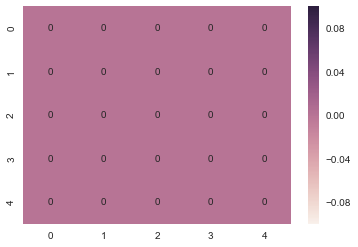

In [5]:
sns.heatmap(values, annot=True)

## Successor Representation

In [11]:
def state2idx(state):
    for i in range(len(all_states)):
        if np.all(all_states[i] == state):
            return i

def M(s, s_new):
#     idx_s = s[1] + maze.shape[1] * s[0]
#     idx_s_new = s_new[1] + maze.shape[1] * s_new[0]
    idx_s = state2idx(s)
    idx_s_new = state2idx(s_new)
    return sr_matrix[idx_s, idx_s_new]

def set_M(s, s_new, value, sr_matrix):
#     idx_s = s[1] + maze.shape[1] * s[0]
#     idx_s_new = s_new[1] + maze.shape[1] * s_new[0]
    idx_s = state2idx(s)
    idx_s_new = state2idx(s_new)
    sr_matrix[idx_s, idx_s_new] = value
    
def random_policy(s, beta=5):
    possible_next_states = [s + d for d in np.array([[1,0],[-1,0],[0,1],[0,-1]])]
    filtered = list(filter(valid_state, possible_next_states))
    vs = np.array([1 for s in filtered])
    p = softmax(vs, beta)
    return filtered[np.random.choice(range(len(filtered)), 1, p=p)[0]]

def same_state(s1, s2):
    return np.all(s1 == s2)

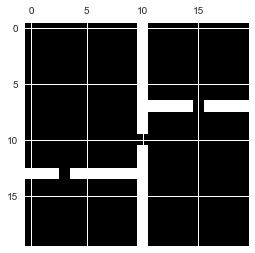

In [21]:
maze = np.ones((20, 20))
maze[:, 10] = 0
maze[13, range(10)] = 0
maze[7, range(10, 20)] = 0
maze[10,10] = 1
maze[13,3] = 1
maze[7,15] = 1
plt.matshow(maze)

In [136]:
maze = np.ones((20,20))
# r = np.zeros(maze.shape, dtype=np.float)
# r[2,3] = 1.0
values = np.zeros(maze.shape, dtype=np.float)
visited = np.zeros(maze.shape)
all_states = [np.array(s) for s in it.product(range(maze.shape[0]), range(maze.shape[1])) if maze[s[0], s[1]] == 1]
n_states = maze.shape[0] * maze.shape[1]
sr_matrix = np.eye(len(all_states), dtype=np.float)

s_0 = np.array([0,0])

s_new = s_0
s = None

alpha = 0.1
gamma = 0.9


for i in range(100):
    s = s_new
    s_new = random_policy(s)
    
#     new_V = V(s) + alpha * (R(s) + gamma * V(s_new) - V(s))
#     set_V(s, new_V)
    inc_visited(s_new)
    next_sr_matrix = sr_matrix.copy()
    for s_prime in all_states:
        I = 1 if same_state(s, s_prime) else 0
        new_M = M(s, s_prime) + alpha * (I + gamma * M(s_new, s_prime) - M(s, s_prime))
        set_M(s, s_prime, new_M, next_sr_matrix)
    sr_matrix = next_sr_matrix
    
#     if R(s_new) != 0:
#         s_new = s_0
    

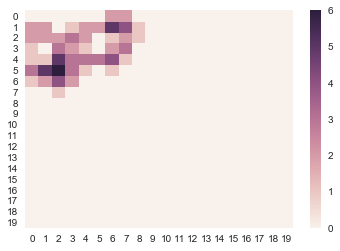

In [137]:
sns.heatmap(visited)

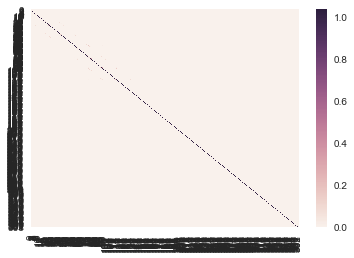

In [138]:
sns.heatmap(sr_matrix)

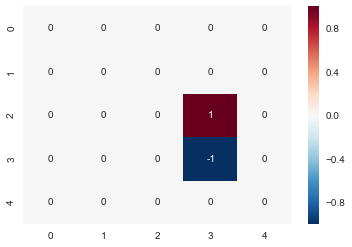

In [76]:
reward_vec = np.array(r.flatten())
v_sr = (sr_matrix @ reward_vec).reshape(maze.shape)
sns.heatmap(v_sr, annot=True)
plt.show()
# v_sr

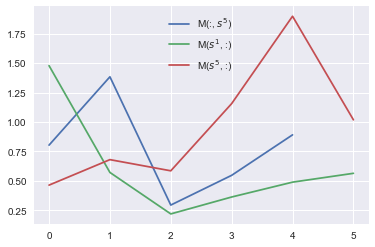

In [632]:
path = np.array(all_states)[[8,4,0,1,2,3]]
sr_vals = [M(s, all_states[3]) for s in path[:-1]]
plt.plot(sr_vals, label='M(:, $s^5$)')


sr_vals = [M(s, all_states[8]) for s in path]
plt.plot(sr_vals, label='M($s^1$, :)')

sr_vals = [M(s, all_states[2]) for s in path]
plt.plot(sr_vals, label='M($s^5$, :)')
plt.legend()
plt.show()

In [633]:
alt_r = np.array([
    [0,0,0,1],
    [0,0,0,-1],
    [0,0,0,-1]
    
])

alt_reward_vec = np.array(alt_r.flatten())
alt_v_sr = (sr_matrix @ alt_reward_vec).reshape(maze.shape)
sns.heatmap(alt_v_sr, annot=True)
plt.show()
alt_v_sr

ValueError: shapes (25,25) and (12,) not aligned: 25 (dim 1) != 12 (dim 0)

### Compute SR with transition matrix T

In [55]:
def transition_matrix(maze):
    m = make_matrix_from(maze)
    return m / m.sum(axis=1)

def make_matrix(rows, cols):
    n = rows*cols
    M = np.zeros((n,n))
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            # Two inner diagonals
            if c > 0: M[i-1,i] = M[i,i-1] = 1
            # Two outer diagonals
            if r > 0: M[i-cols,i] = M[i,i-cols] = 1
    return M

def make_matrix_from(maze):
    
    def in_maze(s):
        return s[0] >= 0 and s[0] < maze.shape[0] and s[1] >= 0 and s[1] < maze.shape[1]

    def is_free(s):
        return maze[s[0],s[1]] == 1

    def valid_state(s):
        return in_maze(s) and is_free(s)
    
    states = [np.array(s) for s in it.product(range(maze.shape[0]), range(maze.shape[1])) if maze[s[0], s[1]] == 1]
    adja = np.eye(len(states))
    idx = np.zeros(maze.shape, dtype=np.int)
    c = 0
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == 0:
                continue
            idx[i, j] = c
            c += 1
    
    for i, state in enumerate(states):
        possible_next_states = [state + d for d in np.array([[1,0],[-1,0],[0,1],[0,-1]])]
        filtered = list(filter(valid_state, possible_next_states))
        for f in filtered:
            adja[i, idx[f[0], f[1]]] = 1
            adja[idx[f[0], f[1]], i] = 1
    return adja
        

def sr_matrix_from(maze, gamma):
    T = transition_matrix(maze)
    n = T.shape[0]
    return np.linalg.inv(np.eye(n) - gamma * T)

## Eigendecomposition

In [75]:
def eigdecomp(M):
    E, V = np.linalg.eig(M)
    idx = np.argsort(E)[::-1]
    return V[:, idx[:]].astype(float), E

def eig2maze(eig, maze):
    eig_iter = iter(eig)
    res = []
    walls = []
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == 1:
                res.append(next(eig_iter))
            else:
                res.append(0)
    return np.array(res).reshape(maze.shape)

def plot_eigvecs(eig_vecs, maze, grid_size=10, filename=None, figsize=(15,15)):
    plt.figure(figsize=figsize)
    for i in range(eig_vecs.shape[0]):
        if i >= grid_size**2:
            break
        ax = plt.subplot(grid_size, grid_size, i+1)
        ax.matshow(eig2maze(eig_vecs[:, i+1], maze), cmap='RdBu_r')
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        plt.grid(False)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
def plot_from_maze(maze, filename=None, figsize=(15,15), grid_size=5, gamma=0.9):
    M = sr_matrix_from(maze, gamma)
    V, E = eigdecomp(M)
    V[V < 0] = 0
    plot_eigvecs(V, maze, grid_size=grid_size, filename=filename, figsize=figsize)


/Users/nico/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:4: ComplexWarning: Casting complex values to real discards the imaginary part


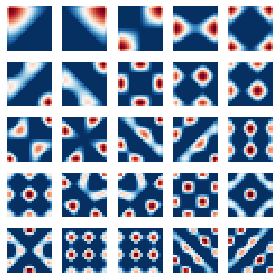

In [61]:
plot_from_maze(open_maze(20), figsize=(4,4), filename='square.pdf', gamma=0.9)

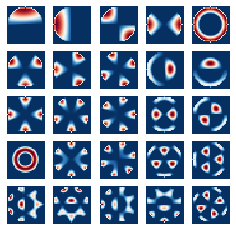

In [49]:
plot_from_maze(circular_maze(30), figsize=(4,4), filename='circle.pdf')

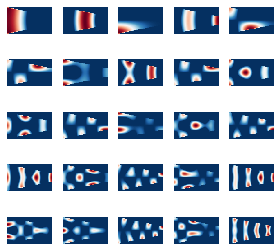

In [63]:
plot_from_maze(trapezoidal_maze(20, 5), figsize=(4,4), filename='trapezoidal.pdf')

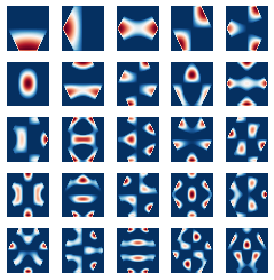

In [62]:
plot_from_maze(hexagonal_maze(10), figsize=(4,4), filename='hexagon.pdf', gamma=0.9)

## Subgoal discovery

In [148]:
def compute_cut(orig_maze, mask, d):
    maze = np.zeros(orig_maze.shape)
    maze[np.logical_and(orig_maze, mask)] = 1
    M = sr_matrix_from(maze, 0.9)
    V, E = eigdecomp(M)
    cut = V.copy()
    cut[V < 0] = 0
    cut[V > 0] = 1
    cut = cut[:,1]
    cut1 = eig2maze(cut, np.logical_and(maze, mask))
    cut2 = eig2maze(np.invert(cut.astype(int))+2, np.logical_and(maze, mask))
    
    res = np.zeros(orig_maze.shape)
    res[orig_maze == 0] = -1
    res[cut1 == 1] = 2
    res[cut2 == 1] = 3
    yield res    
    if d < 3:
        yield from compute_cut(orig_maze, np.logical_and(mask, cut1), d+1)
        yield from compute_cut(orig_maze, np.logical_and(mask, cut2), d+1)

def cut_approx(maze):
    yield from compute_cut(maze, np.ones(maze.shape), 1)
    

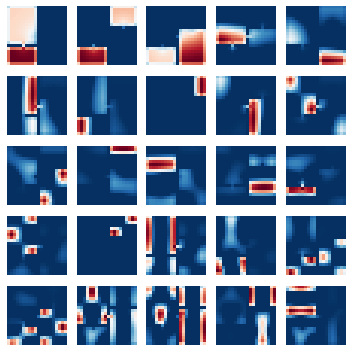

In [76]:
plot_from_maze(multicomp_maze(), figsize=(5,5))

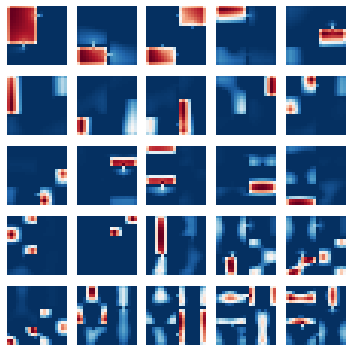

In [153]:
plot_from_maze(multicomp_maze_circ(), figsize=(5,5))

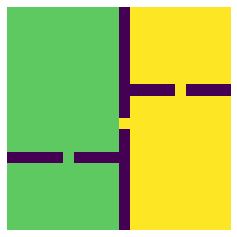

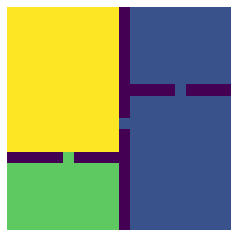

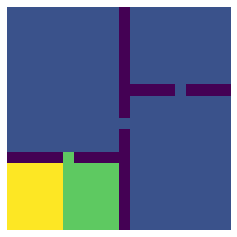

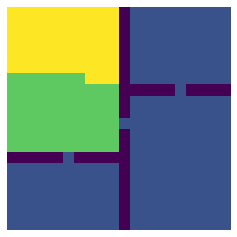

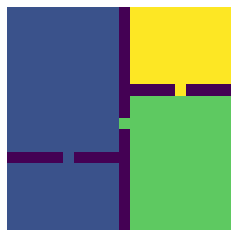

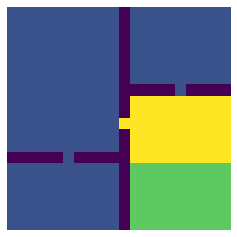

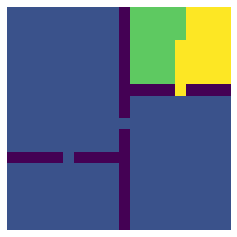

In [149]:
for i, c in enumerate(cut_approx(multicomp_maze())):
    plt.sub
    plt.matshow(c, cmap='viridis')
    plt.grid(False)
    plt.gca().axes.get_xaxis().set_ticks([])
    plt.gca().axes.get_yaxis().set_ticks([])
    plt.savefig('cut_{}.pdf'.format(i))

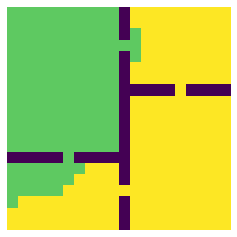

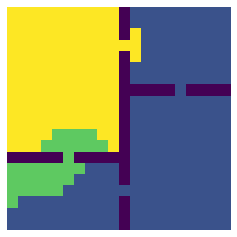

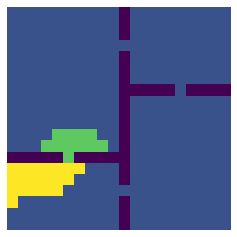

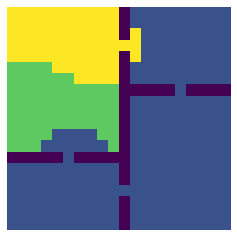

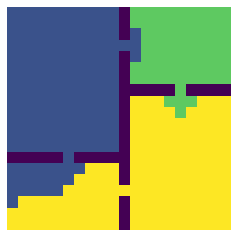

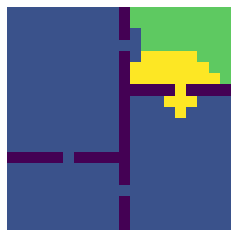

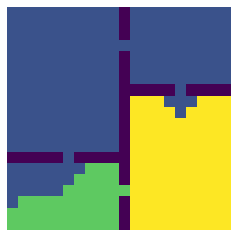

In [158]:
for i, c in enumerate(cut_approx(multicomp_maze_circ())):
    plt.matshow(c, cmap='viridis')
    plt.grid(False)
    plt.gca().axes.get_xaxis().set_ticks([])
    plt.gca().axes.get_yaxis().set_ticks([])
    plt.savefig('circ_cut_{}.pdf'.format(i), bbox_inches='tight')
    plt.show()